# 13 금융 시계열 분석(시장을 이기는 법)

## 13.1 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 여기에서는 Close만 사용하겠다. (주식 시장은 정해진 시간 동안만 거래가 가능하다. 종가란 하루의 장이 마감하였을 때의 가격이다)


In [1]:
# 애플의 주식 데이터를 가져와 본다
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-24    74.544998
2020-02-25    72.019997
2020-02-26    73.162498
2020-02-27    68.379997
2020-02-28    68.339996
Name: Close, dtype: float64

## 13.2 각종 전처리 수행

In [2]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [3]:
# 로드 변환
ts_log = np.log(ts)

# 13.3 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

아래는 일정 시간내 구간 통계치(Rolling Statistics) 를 시각화해 보는 함수다. 현재 타임스텝부터 window에 주어진 타임스텝 이전 사이 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화해 보면 좀더 뚜렷한 경향성을 확인할 수 있을 것이다.

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동 표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해보자
    orig = plt.plot(timeseries, color='blue', label = 'Original')
    mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Derivatioin")
    plt.show(block = False)

아래는 Augmented Dickey-Fuller Test라는 시계열 데이터의 안정성을 테스트하는 통계적 방법이 있다. 이 테스트는 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis) 를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis) 을 채택한다는 내용이다.

In [5]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodel 패키지에서 제공하는 adfuller 메소드를 호출한다
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

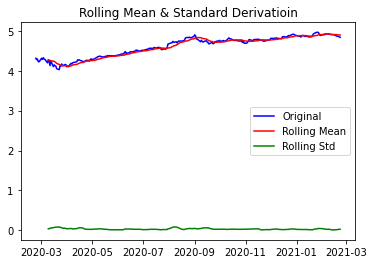

Results of Dickey-Fuller Test:
Test Statistic                  -1.113776
p-value                          0.709547
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


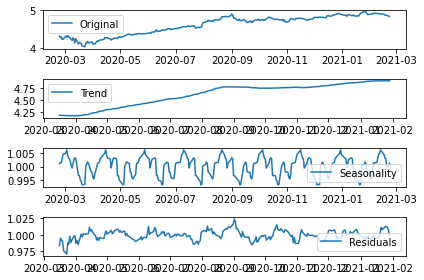

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                -6.710472e+00
p-value                        3.691712e-09
#Lags Used                     5.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


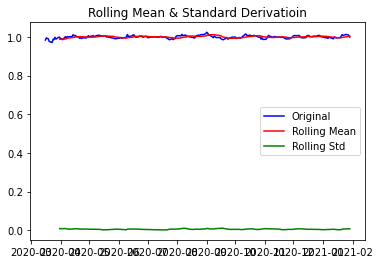

In [7]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
plot_rolling_statistics(residual)

## 13.4 학습, 테스트 데이터셋 생성

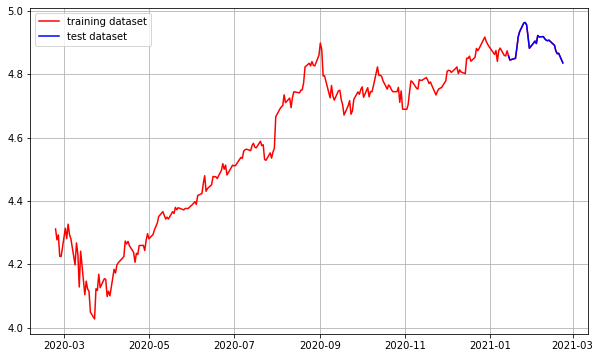

In [8]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 13.5 적정 ARIMA 모수 찾기

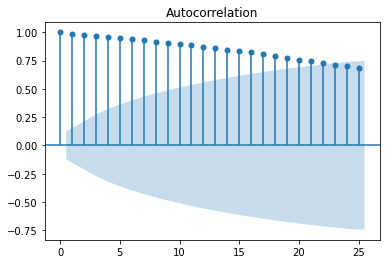

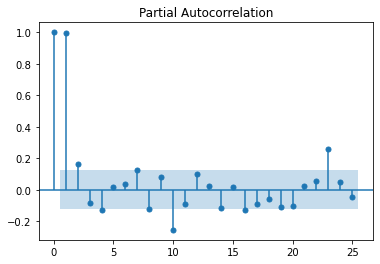

In [9]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.775306
p-value                          0.000061
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


"\n# 혹시 필요한 경우 2차 차분 구하기\ndiff_2 = diff_1.diff(periods=1).iloc[1:]\ndiff_2.plot(title='Difference 2nd')\n\naugmented_dickey_fuller_test(diff_2)\n"

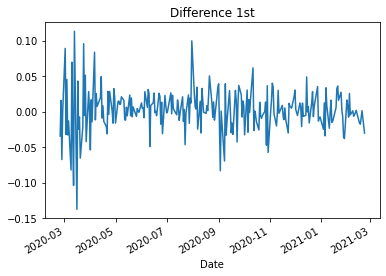

In [10]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


'''
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
'''

## 13.6 ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 476.068
Method:                       css-mle   S.D. of innovations              0.029
Date:                Tue, 23 Feb 2021   AIC                           -946.135
Time:                        11:34:16   BIC                           -935.887
Sample:                             1   HQIC                          -941.999
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0025      0.002      1.681      0.093      -0.000       0.005
ar.L1.D.Close    -0.2952      0.064     -4.630      0.000      -0.420      -0.170
                                    Root

/home/asnkmgsk/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/asnkmgsk/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been 

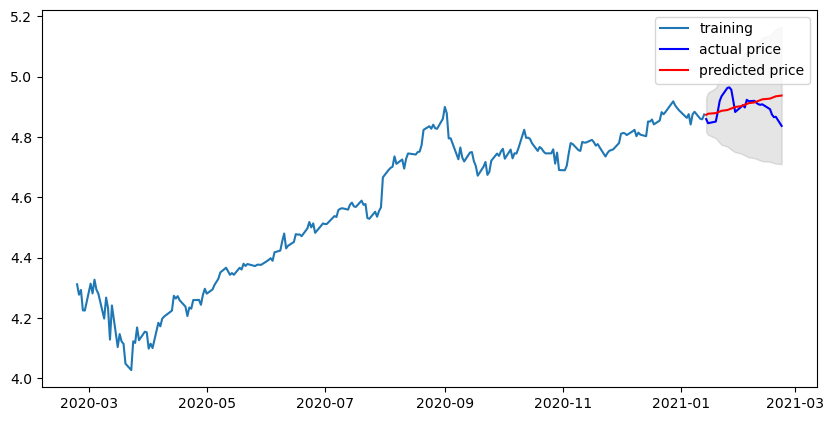

In [19]:
# Forecast : 결과가 fc에 담긴다
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  31.826979521579354
MAE:  4.244687888753921
RMSE:  5.641540527336425
MAPE: 3.16%


## 13.7 다른 주식 종목 예측해 보기

In [21]:
# 구글
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOGL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-24    1419.859985
2020-02-25    1386.319946
2020-02-26    1390.469971
2020-02-27    1314.949951
2020-02-28    1339.250000
Name: Close, dtype: float64

In [22]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력한다

Series([], Name: Close, dtype: float64)

In [23]:
# 로드 변환
ts_log = np.log(ts)

In [24]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동 표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해보자
    orig = plt.plot(timeseries, color='blue', label = 'Original')
    mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Derivatioin")
    plt.show(block = False)

In [25]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodel 패키지에서 제공하는 adfuller 메소드를 호출한다
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

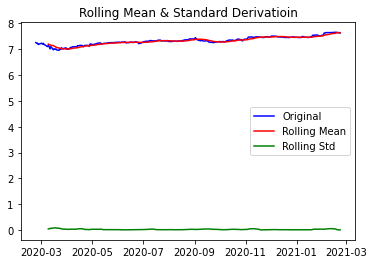

Results of Dickey-Fuller Test:
Test Statistic                  -0.797228
p-value                          0.819935
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


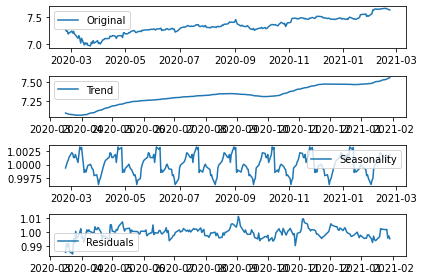

In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                -6.548971e+00
p-value                        8.950224e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


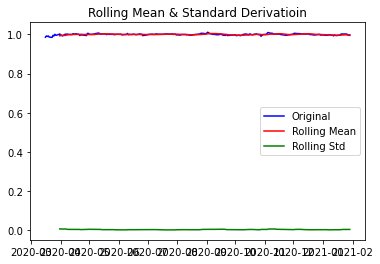

In [27]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
plot_rolling_statistics(residual)

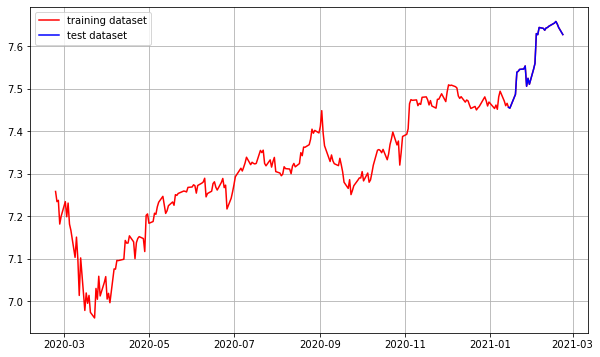

In [28]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

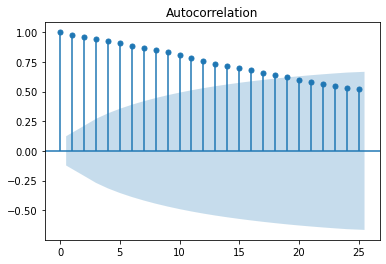

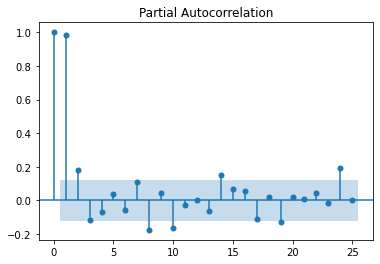

In [29]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.445949
p-value                          0.000246
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


"\n# 혹시 필요한 경우 2차 차분 구하기\ndiff_2 = diff_1.diff(periods=1).iloc[1:]\ndiff_2.plot(title='Difference 2nd')\n\naugmented_dickey_fuller_test(diff_2)\n"

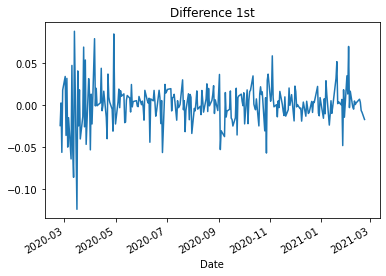

In [30]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


'''
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
'''

In [66]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 522.053
Method:                       css-mle   S.D. of innovations              0.024
Date:                Tue, 23 Feb 2021   AIC                          -1038.106
Time:                        11:48:24   BIC                          -1027.858
Sample:                             1   HQIC                         -1033.970
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      0.793      0.428      -0.001       0.003
ar.L1.D.Close    -0.3323      0.063     -5.290      0.000      -0.455      -0.209
                                    Root

/home/asnkmgsk/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/asnkmgsk/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been 

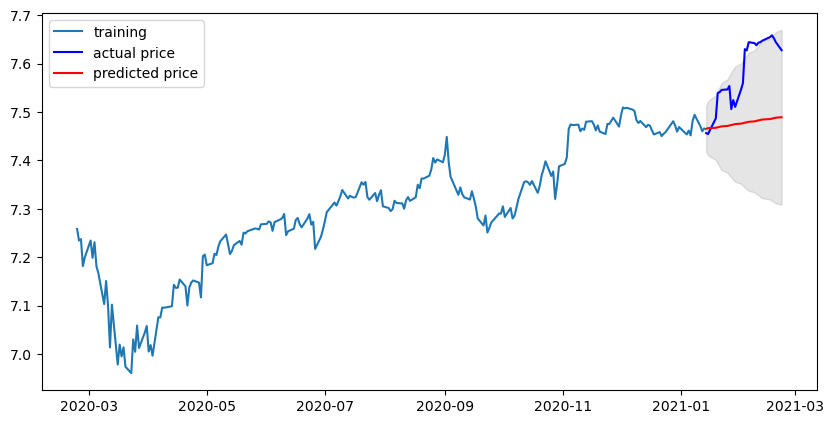

In [67]:
# Forecast : 결과가 fc에 담긴다
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  53055.1993135824
MAE:  201.456637624921
RMSE:  230.33714271385412
MAPE: 9.91%


In [70]:
# Agilysys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AGYS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-24    33.500000
2020-02-25    32.580002
2020-02-26    31.590000
2020-02-27    30.879999
2020-02-28    32.130001
Name: Close, dtype: float64

In [71]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력한다

Series([], Name: Close, dtype: float64)

In [72]:
# 로드 변환
ts_log = np.log(ts)

In [73]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동 표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해보자
    orig = plt.plot(timeseries, color='blue', label = 'Original')
    mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Derivatioin")
    plt.show(block = False)

In [74]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodel 패키지에서 제공하는 adfuller 메소드를 호출한다
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

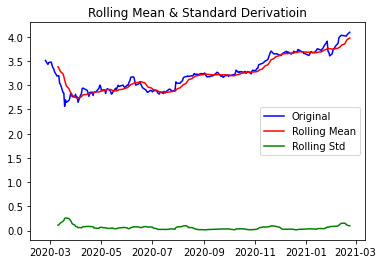

Results of Dickey-Fuller Test:
Test Statistic                  -0.003465
p-value                          0.958245
#Lags Used                       3.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


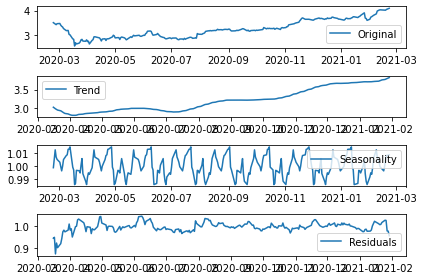

In [75]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                -6.694742e+00
p-value                        4.026103e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


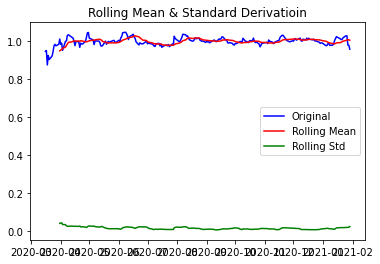

In [76]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
plot_rolling_statistics(residual)

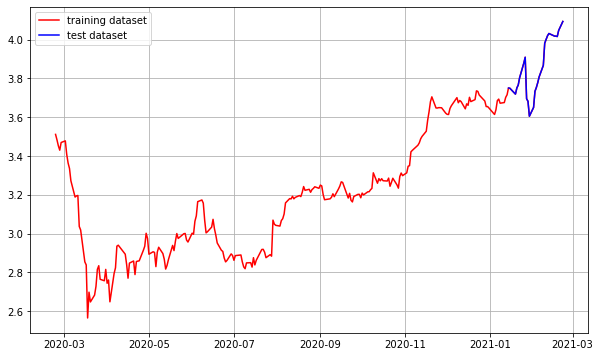

In [77]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

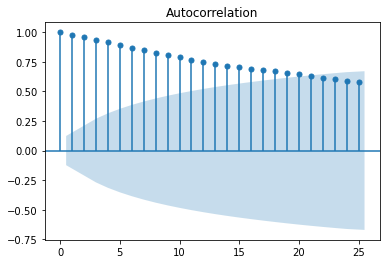

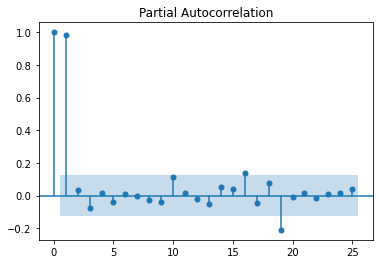

In [78]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.015867e+00
p-value                        6.735510e-10
#Lags Used                     4.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


"\n# 혹시 필요한 경우 2차 차분 구하기\ndiff_2 = diff_1.diff(periods=1).iloc[1:]\ndiff_2.plot(title='Difference 2nd')\n\naugmented_dickey_fuller_test(diff_2)\n"

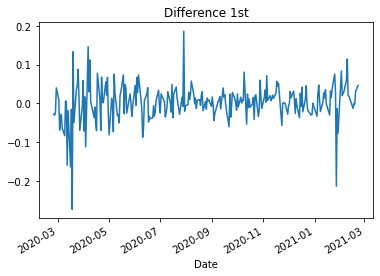

In [79]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


'''
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
'''

In [102]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 2, 12))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/asnkmgsk/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/asnkmgsk/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been 

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                ARIMA(0, 2, 12)   Log Likelihood                 381.502
Method:                       css-mle   S.D. of innovations              0.044
Date:                Tue, 23 Feb 2021   AIC                           -735.005
Time:                        11:57:38   BIC                           -687.242
Sample:                             2   HQIC                          -715.725
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0001   6.37e-05      1.659      0.097   -1.91e-05       0.000
ma.L1.D2.Close     -1.0590      0.068    -15.624      0.000      -1.192      -0.926
ma.L2.D2.Close      0.2606      

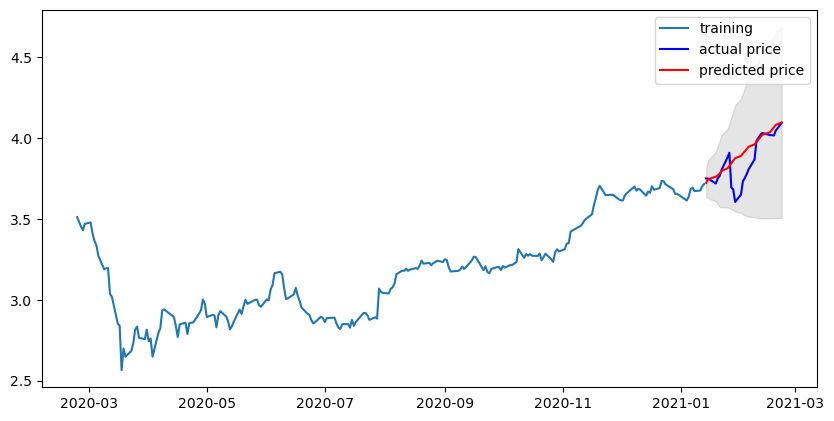

In [103]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  24.208164558336453
MAE:  3.54673390911526
RMSE:  4.920179321766276
MAPE: 8.29%


## 13.8 회고

이번 프로젝트에서는 주식 시계열 데이터를 가져와서 ARIMA모형으로 분석하는 작업을 했다. 결론적으로는 ARIMA 모형같은 전통적인 모델따위로는 시장을 예측해서 이길 수 없다는 것이다. 아직 노드에서는 다른 최신모델과 전처리 기법을 사용하여 좀 더 치밀하게 금융데이터를 분석하는 프로젝트가 나오지는 않았는데, 얼른 나와서 프로젝트를 한 번 진행해보고 싶다.   

결론 : 옛날 모델 쓰지 말자

하...오늘 0시 30분에 저번주에 끝냈어야 할 프로젝트인 GAN을 드디어 끝냈다...(지금까지는 첫째주 화, 목에 프로젝트 2개를 시작했다고 할 때, 첫째주에 모두 끝마쳤다...)sigmoid라는 해법을 적용하기까지 너무나도 오랜시간이 걸렸다. 프로젝트 마감일이 목요일이라면, 먼저 git에 올린 후, 링크를 제출하고 채점이 되기 전까지 계속해서 수정을 할 수는 있지만, 아까 전, 10시15분에 오타와 회고, 결과그림을 조금 바꾼것을 마지막으로 모델을 다시 돌리는 일은 다시는 없을 것이다. 어제까지 모델을 쉴새없이 돌렸고, 그 여파인지 오늘 꿈에는 GAN모델 돌리는 꿈까지 꿨다...물론 모델을 더 개선 할 수 있겠지만, 더 했다가는 멘탈이 위험할 거 같아서 그만 탈출하겠다.